In [1]:
%pylab inline
import numpy as np
import unittest
import math

import gzip, pickle

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Softmax

In [2]:
def softmax(v):
    e_x = np.exp(v - np.amax(v, axis=1))
    return e_x/e_x.sum(axis=1)

In [3]:
def fprop(W1, W2, b1, b2, x, y=None):
    ha = np.dot(x, np.transpose(W1)) + b1
    hs = np.maximum(np.zeros(ha.shape), ha)

    oa = np.dot(hs, np.transpose(W2))  + b2
    os = softmax(oa)
    
    if y is None:
        loss = None
    else:
        y = y.astype(int)
        #loss = -1*np.log(os[np.arange(len(os)),y.getA1()])
        loss = -1*np.log(os[np.arange(len(os)),y])

    return {
        'ha': ha,
        'hs': hs,
        'oa': oa,
        'os': os,
        'loss': loss
    }

In [4]:
def bprop(fprop, W1, W2, b1, b2, x, y, m):
    y = y.astype(int)
    grad_oa = fprop['os'] - np.eye(m)[y]

    grad_b2 = np.sum(grad_oa, axis=0)
    #devrait être grad_w2 = np.dot(grad_oa,np.transpose(fprop['hs']))
    #grad_w2 = np.dot(np.transpose(grad_oa), fprop['hs']) #original eq de Mahmoud
    grad_w2 = np.transpose(np.dot(np.transpose(fprop['hs']),grad_oa))#doit ajouter np.transpose sur toute l'éq
    #devrait être grad_hs = np.dot(np.transpose(W2),grad_oa) MAIS NE FONCTIONNE PAS
    grad_hs = np.dot(grad_oa, W2) #original eq de Mahmoud
    #devrait être grad_ha = np.where(fprop['ha'])>=0,grad_hs,np.zeros(fprop['ha'].shape))
    #grad_ha = np.where(np.sign(fprop['ha'])+1,grad_hs,np.zeros(fprop['ha'].shape)) #original eq de Mahmoud
    grad_ha = np.where(fprop['ha']>=0,grad_hs,np.zeros(fprop['ha'].shape))
    grad_b1 = np.sum(grad_ha, axis=0)
    #devrait être grad_w1 = np.dot(grad_ha,np.transpose(x))
    #grad_w1 = np.dot(np.transpose(grad_ha),x) / x.shape[0] #original eq de Mahmoud
    grad_w1 = np.transpose(np.dot(np.transpose(x),grad_ha))#doit ajouter np.transpose sur toute l'éq
    return {
        'grad_w1': grad_w1,
        'grad_b1': grad_b1,
        'grad_ha': grad_ha,
        'grad_hs': grad_hs,
        'grad_w2': grad_w2,
        'grad_b2': grad_b2,
        'grad_oa': grad_oa
    }

In [5]:
np.random.seed(1234)

## Question 1

In [6]:
data = np.matrix([[12, 22, 0]])

x = data[:,:-1]
y = data[:,-1].getA1()

dh = 2
d = 2
m = 2
epsilon = 1e-5

# Initialisation des paramètres
W1 = np.random.uniform(
    -1 / math.sqrt(d), 
    1 / math.sqrt(d), 
    (dh, d))
b1 = np.zeros((1, dh))

W2 = np.random.uniform(
    -1 / math.sqrt(dh), 
    1 / math.sqrt(dh), 
    (m, dh))
b2 = np.zeros((1,m))

In [7]:
fprop_r = fprop(W1, W2, b1, b2, x, y)

In [8]:
bprop_r = bprop(fprop_r, W1, W2, b1, b2, x, y, m)

In [9]:
L = fprop_r['loss']

#### Verification du W2 gradient 

In [10]:
def check_grad_w2(L, W1, W2, b1, b2, x, y, epsilon):
    grad_diff = np.zeros(W2.shape)

    for i in list(range(W2.shape[0])):
        for j in list(range(W2.shape[1])):
            W2[i, j] += epsilon

            fprop_r_diff = fprop(W1, W2, b1, b2, x, y)

            L_prime = np.sum(fprop_r_diff['loss'])

            W2[i, j] -= epsilon

            grad_diff[i,j] = (L_prime - L) / epsilon
            
    return grad_diff

In [11]:
grad_w2_diff = check_grad_w2(L, W1, W2, b1, b2, x, y, epsilon)

print(grad_w2_diff)
print((bprop_r['grad_w2'] + epsilon) / (grad_w2_diff + epsilon))

[[ 0.         -7.79911931]
 [ 0.          7.79912105]]
[[ 1.          1.00000011]
 [ 1.          0.99999989]]


#### Verification du b2 gradient

In [12]:
def check_grad_b2(L, W1, W2, b1, b2, x, y, epsilon):    
    grad_diff = np.zeros(b2.shape)

    for i in list(range(b2.shape[1])):
        b2[0, i] += epsilon

        fprop_r_diff = fprop(W1, W2, b1, b2, x, y)

        L_prime = np.sum(fprop_r_diff['loss'])

        b2[0, i] -= epsilon

        grad_diff[0, i] = (L_prime -L) / epsilon
        
    return grad_diff

In [13]:
grad_b2_diff = check_grad_b2(L, W1, W2, b1, b2, x, y, epsilon)

print(grad_b2_diff)
print((bprop_r['grad_b2'] + epsilon) / (grad_b2_diff + epsilon))

[[-0.99714118  0.99714121]]
[[ 1.00000001  0.99999999]]


#### Verification du W1 gradient

In [14]:
def check_grad_w1(L, W1, W2, b1, b2, x, y, epsilon):   
    grad_diff = np.zeros(W1.shape)

    for i in list(range(W1.shape[0])):
        for j in list(range(W1.shape[1])):
            W1[i, j] += epsilon

            fprop_r_diff = fprop(W1, W2, b1, b2, x, y)

            L_prime = np.sum(fprop_r_diff['loss'])

            W1[i, j] -= epsilon

            grad_diff[i,j] = (L_prime - L) / epsilon

    return grad_diff

In [15]:
grad_w1_diff = check_grad_w1(L, W1, W2, b1, b2, x, y, epsilon)

print(grad_w1_diff)
print((bprop_r['grad_w1'] + epsilon) / (grad_w1_diff + epsilon))

[[  0.           0.        ]
 [  8.9564951   16.42024278]]
[[ 1.          1.        ]
 [ 0.99999987  0.99999976]]


#### Verification du b1 gradient

In [16]:
def check_grad_b1(L, W1, W2, b1, b2, x, y, epsilon):
    grad_diff = np.zeros(b1.shape)

    for i in list(range(b1.shape[1])):
        b1[0, i] += epsilon

        fprop_r_diff = fprop(W1, W2, b1, b2, x, y)

        L_prime = np.sum(fprop_r_diff['loss'])

        b1[0, i] -= epsilon

        grad_diff[0, i] = (L_prime -L) / epsilon
        
    return grad_diff

In [17]:
grad_b1_diff = check_grad_b1(L, W1, W2, b1, b2, x, y, epsilon)

print(grad_b1_diff)
print((bprop_r['grad_b1'] + epsilon) / (grad_b1_diff + epsilon))

[[ 0.         0.7463745]]
[[ 1.          0.99999999]]


## Question 2

In [18]:
class MLP:
    def __init__(self, d, m, dh, epsilon,nEpoc):
        self.total_grad = 0
        self.m = m
        self.epsilon = epsilon
        self.d = d
        self.dh = dh
        self.nEpoc = nEpoc
       
        # Initialisation des paramètres
        self.W1 = np.random.uniform(
            -1 / math.sqrt(d), 
            1 / math.sqrt(d), 
            (dh, d))
        self.b1 = np.zeros((1, dh))

        self.W2 = np.random.uniform(
            -1 / math.sqrt(dh), 
            1 / math.sqrt(dh), 
            (m, dh))
        self.b2 = np.zeros((1, m))
        
    def verify_gradient(self, train, target, k):
        for i in list(range(k)):
            x = train[i]
            y = target[i]
            
            fprop_r = fprop(self.W1, self.W2, self.b1, self.b2, x, y)
            bprop_r = bprop(fprop_r, self.W1, self.W2, self.b1, self.b2, x, y, self.m)
            L = fprop_r['loss']

            grad_w2_diff = check_grad_w2(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)
            grad_w1_diff = check_grad_w1(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)
            grad_b2_diff = check_grad_b2(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)
            grad_b1_diff = check_grad_b1(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)

            grad_ratio_b1 = (bprop_r['grad_b1'] + self.epsilon) / (grad_b1_diff + self.epsilon)
            grad_ratio_w1 = (bprop_r['grad_w1'] + self.epsilon) / (grad_w1_diff + self.epsilon)
            grad_ratio_b2 = (bprop_r['grad_b2'] + self.epsilon) / (grad_b2_diff + self.epsilon)
            grad_ratio_w2 = (bprop_r['grad_w2'] + self.epsilon) / (grad_w2_diff + self.epsilon)

            def check_grad_ratio(ratio):
                return (ratio > 0.99).all() and (ratio < 1.01).all()

            if check_grad_ratio(grad_ratio_b2) and check_grad_ratio(grad_ratio_w2) and check_grad_ratio(grad_ratio_b1) and check_grad_ratio(grad_ratio_w1):
                print('Gradient verified for element {0} ✓'.format(i))
            else:
                print('Gradient error for element {0} X'.format(i))
    
 
    def batch_train(self, train, target, lamdas, learning_rate, k):
        self.total_grad = 0
        
        split_indices = list(range(k, train.shape[0], k))
        train_splits = np.split(train, split_indices)
        target_splits = np.split(target, split_indices)
        
        for i in list(range(0, len(train_splits) - 1, 1)):
            x = train_splits[i]
            y = target_splits[i]
            
            self.train(x, y, lamdas, learning_rate)
        
    def test(self,test,target):
        classesPredS = []
        for x in test:
            os = fprop(self.W1, self.W2, self.b1, self.b2, x)['os']
            classesPredS.append(np.argmax(os,axis=1)+1)
        error = 0
        for i in range(len(target)):
            if target[i] != classesPredS[i]-1:
                error += 1
        errorP = 100.0*float(error)/float(len(target))
        return errorP
        
        
    def train(self, train, target, lamdas, learning_rate):
        errorEpoc = []
        for j in range(self.nEpoc):
            for i in list(range(train.shape[0])):
                x = train[i]
                y = target[i]
            
                fprop_r = fprop(self.W1, self.W2, self.b1, self.b2, x, y)
                bprop_r = bprop(fprop_r, self.W1, self.W2, self.b1, self.b2, x, y, self.m)
            
                self.total_grad += np.average(bprop_r['grad_oa'])
            
                regularization = lamdas[0,0]*self.W1.sum() + \
                    lamdas[0,1]*np.square(self.W1).sum() + \
                    lamdas[1,0]*self.W2.sum() + \
                    lamdas[1,1]*np.square(self.W2).sum()
            
                self.W1 -= (learning_rate*bprop_r['grad_w1'] + regularization)
                self.W2 -= (learning_rate*bprop_r['grad_w2'] + regularization)
            
                self.b1 -= (learning_rate*bprop_r['grad_b1'] + regularization)
                self.b2 -= (learning_rate*bprop_r['grad_b2'] + regularization)
            errorEpoc.append(self.test(train,target))
        return errorEpoc
            
    def show_decision_regions(self, train_data):
        def combine(*seqin):
            '''returns a list of all combinations of argument sequences.
            for example: combine((1,2),(3,4)) returns
            [[1, 3], [1, 4], [2, 3], [2, 4]]'''
            def rloop(seqin,listout,comb):
                '''recursive looping function'''
                if seqin:                       # any more sequences to process?
                    for item in seqin[0]:
                        newcomb=comb+[item]     # add next item to current comb
                        # call rloop w/ rem seqs, newcomb
                        rloop(seqin[1:],listout,newcomb)
                else:                           # processing last sequence
                    listout.append(comb)        # comb finished, add to list
                    
            listout=[]                      # listout initialization
            rloop(seqin,listout,[])         # start recursive process
            return listout

        plt.figure()
        d1 = train_data[train_data[:, -1].getA1() > 0]
        d2 = train_data[train_data[:, -1].getA1() == 0]
        
        plt.scatter(d1[:, 0], d1[:, 1], c='b', label='classe 1')
        plt.scatter(d2[:, 0], d2[:, 1], c='g', label='classe 0')

        xgrid = np.linspace(np.min(train_data[:, 0]) - 0.5,
                        np.max(train_data[:, 0]) + 0.5,
                        100)
        ygrid = np.linspace(np.min(train_data[:, 1]) - 0.5,
                        np.max(train_data[:, 1]) + 0.5,
                        100)

        # calcule le produit cartesien entre deux listes
        # et met les resultats dans un array
        thegrid = np.array(combine(xgrid,ygrid))
        classesPred = []
        for x in thegrid:
            os = fprop(self.W1, self.W2, self.b1, self.b2, x)['os']
            classesPred.append(np.argmax(os,axis=1)+1)
        
        pylab.pcolormesh(xgrid, ygrid, np.array(classesPred).reshape((100, 100)).T, alpha=.3)
        plt.xlim(np.min(train_data[:, 0]) - 0.5, np.max(train_data[:, 0]) + 0.5)
        plt.ylim(np.min(train_data[:, 1]) - 0.5, np.max(train_data[:, 1]) + 0.5)
        plt.grid()
        plt.legend(loc='lower right')
        plt.title(title)
        plt.show()

In [19]:
dh = 2
d = 2
m = 2
k = 1
epsilon = 1e-5
nEpoc = 1
nnet = MLP(d, m, dh, epsilon,nEpoc)

In [20]:
nnet.verify_gradient(x,y, k)

Gradient verified for element 0 ✓


## Questions 3 et 4

In [21]:
def TrainingValidationTestSets(dataA,frTr,frVa,frTe):
    random.seed()
    # Determiner au hasard des indices pour les exemples d'entrainement et de test
    n_train = int(frTr*dataA.shape[0])
    n_valid = int(frVa*dataA.shape[0])
    n_test = int(frTe*dataA.shape[0])
    rest = dataA.shape[0] - n_train - n_valid - n_test
    if rest != 0:
        n_train += rest
    inds = list(range(dataA.shape[0]))
    random.shuffle(inds)
    train_inds = inds[:n_train]
    valid_inds = inds[n_train:n_train+n_valid]
    test_inds = inds[n_train+n_valid:]

    # Separer les donnees dans les deux ensembles
    train_set = dataA[train_inds,:]
    valid_set = dataA[valid_inds,:]
    test_set = dataA[test_inds,:]
    print(' len(dataA)= ',len(dataA),' len(train_set)= ',len(train_set), ' len(valid_set)= ',len(valid_set), ' len(test_set)= ',len(test_set))
    print(' len(train_set) + len(valid_set) + len(test_set)= ',len(train_set) + len(valid_set) + len(test_set))
    return train_set,valid_set,test_set

In [22]:
data2Moon = np.matrix(np.loadtxt(open('2moons.txt', 'r')))
frTr = 0.6
frVa = 0.2
frTe = 0.2

#print 'data2Moon.shape = ',data2Moon.shape #(1100, 3)
MoonTrain,MoonValid,MoonTest = TrainingValidationTestSets(data2Moon,frTr,frVa,frTe)

 len(dataA)=  1100  len(train_set)=  660  len(valid_set)=  220  len(test_set)=  220
 len(train_set) + len(valid_set) + len(test_set)=  1100


In [23]:
dh = 2 # nb neurones
d = 2 # nb entrées
m = 2 # nb sorties
k = 10 # nb d'exemples
epsilon = 1e-5
nEpoc = 1
nnet = MLP(d, m, dh, epsilon,nEpoc)

train = MoonTrain[:k, :-1]
target = MoonTrain[:k, -1].getA1()
valid = MoonValid[:, :-1]
targetValid = MoonValid[:, -1].getA1()
test = MoonTest[:, :-1]
targetTest = MoonTest[:, -1].getA1()

nnet.verify_gradient(train, target, k)

Gradient verified for element 0 ✓
Gradient verified for element 1 ✓
Gradient verified for element 2 ✓
Gradient verified for element 3 ✓
Gradient verified for element 4 ✓
Gradient verified for element 5 ✓
Gradient verified for element 6 ✓
Gradient verified for element 7 ✓
Gradient verified for element 8 ✓
Gradient verified for element 9 ✓


## Question 5

#### Cas où on change les paramètres: 5.1 weigth decay, 5.2 nombre de neurones, 5.3 arrêt prématuré

###Cas de base

Cas de base: nb de neurones =  200  Nb d epoque =  1  learning_rate =  0.21  lamdas =  [[  1.00000000e-03   1.10000000e-03]
 [  1.00000000e-04   6.00000000e-05]]
Erreur de training =  20.0 %  errorValid =  20.0 %  errorTest =  22.727272727272727 %


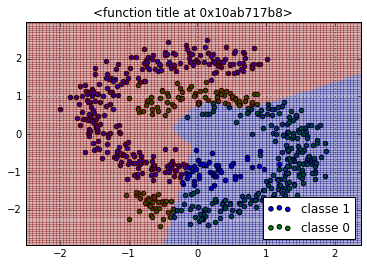

In [24]:
dh = 200
d = 2
m = 2
k = 10
epsilon = 1e-5
nEpoc = 1
nnet = MLP(d, m, dh, epsilon,nEpoc)
lamdas = np.matrix([[0.001, 0.0011],[0.0001, 0.00006]])
#lamdas = np.matrix([[0.001, 0.0006],[0.004, 0.006]])
learning_rate = 0.21

error = nnet.train(train, target, lamdas, learning_rate)
errorValid = nnet.test(valid,targetValid)
errorTest = nnet.test(test,targetTest)
print('Cas de base: nb de neurones = ',dh,' Nb d epoque = ',nEpoc,' learning_rate = ',learning_rate,' lamdas = ',lamdas)
print('Erreur de training = ',error[0],'%',' errorValid = ',errorValid,'%',' errorTest = ',errorTest,'%')
nnet.show_decision_regions(MoonTrain)

#### 5.1 Effet des valeurs des weigth decay

 Cas effet des lamdas - weight decays
Nb de neurones =  200  Nb d epoque =  1  learning_rate =  0.21
lamdas =  [[  1.00000000e-03   1.10000000e-03]
 [  1.00000000e-04   6.00000000e-05]]  erreur de pred a training =  10.0 %
 errorValid =  19.09090909090909 %


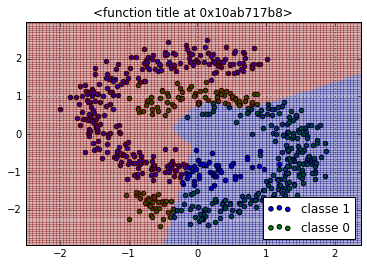

lamdas =  [[ 0.003    0.0031 ]
 [ 0.0003   0.00026]]  erreur de pred a training =  10.0 %
 errorValid =  18.181818181818183 %


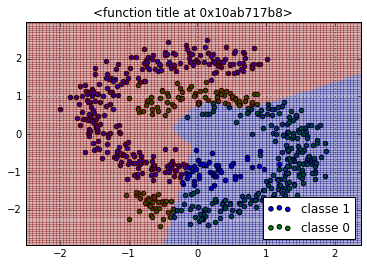

lamdas =  [[ 0.005    0.0051 ]
 [ 0.0005   0.00046]]  erreur de pred a training =  10.0 %
 errorValid =  16.363636363636363 %


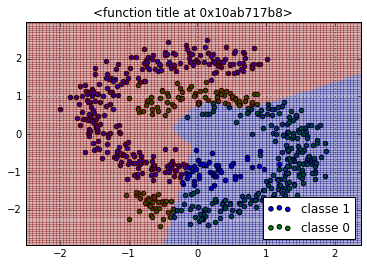

lamdas =  [[ 0.007    0.0071 ]
 [ 0.0007   0.00066]]  erreur de pred a training =  10.0 %
 errorValid =  16.363636363636363 %


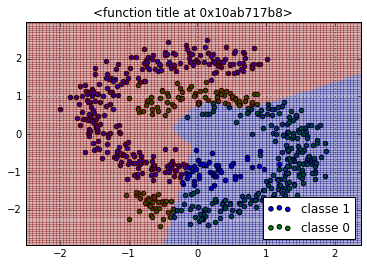

lamdas =  [[ 0.009    0.0091 ]
 [ 0.0009   0.00086]]  erreur de pred a training =  30.0 %
 errorValid =  22.272727272727273 %


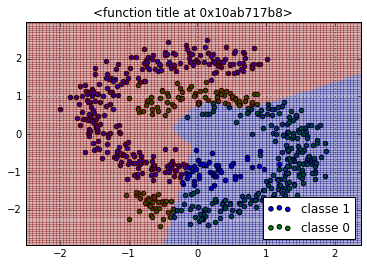

 lamdas à erreur minimale a valid =  [[ 0.005    0.0051 ]
 [ 0.0005   0.00046]]  et erreur de valid min  16.363636363636363 %
A meilleurs lamdas,  erreur train =  10.0 %  errorValid =  13.636363636363637 %  errorTest =  13.181818181818182 %
 Frontiere de decision sur test


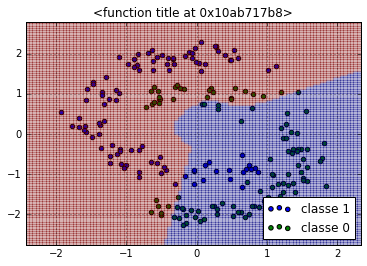

In [25]:
dh = 200 #Nb de neurones
d = 2 # Nb d'entrées
m = 2 # Nb de sorties
k = 10 # min-batch
epsilon = 1e-5
nEpoc = 1
learning_rate = 0.21
#lamdas = np.matrix([[0.001, 0.0011],[0.0001, 0.00006]])
errorVL = []
lamdasList = []
print(' Cas effet des lamdas - weight decays')
print('Nb de neurones = ',dh,' Nb d epoque = ',nEpoc,' learning_rate = ',learning_rate)
nnet2 = MLP(d, m, dh, epsilon,nEpoc)
for i in range(0,10,2):
    k = float(i)/1000   
    lamdas = np.matrix([[0.001+k, 0.0011+k],[0.0001+k/10.0, 0.00006+k/10.0]])
    lamdasList.append(lamdas)
    errorT = nnet2.train(train, target, lamdas, learning_rate)  
    print('lamdas = ',lamdas,' erreur de pred a training = ',errorT[nEpoc-1],'%')
    errorValid = nnet2.test(valid,targetValid)
    errorVL.append(errorValid)
    print(' errorValid = ',errorValid,'%')
    nnet.show_decision_regions(MoonTrain)   
print(' lamdas à erreur minimale a valid = ',lamdasList[argmin(errorVL)],' et erreur de valid min ',min(errorVL),'%')
lamdas = lamdasList[argmin(errorVL)]
errorT = nnet2.train(train, target, lamdas, learning_rate)
errorValid = nnet2.test(valid,targetValid)
errorTest = nnet2.test(test,targetTest)
print('A meilleurs lamdas,',' erreur train = ',errorT[0],'%',' errorValid = ',errorValid,'%',' errorTest = ',errorTest,'%')
print(' Frontiere de decision sur test')
nnet.show_decision_regions(MoonTest)

#### 5.2 Effet du nombre de neurones de la couche cachee

Cas effet du nb de neurones   Nb d epoque =  1  learning_rate =  0.21  lamdas =  [[  1.00000000e-03   1.10000000e-03]
 [  1.00000000e-04   6.00000000e-05]]
Nb de neurones =  50  error pred a train =  20.0 %
 errorValid =  20.0


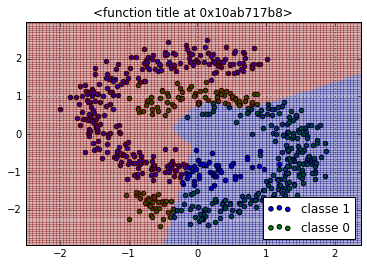

Nb de neurones =  100  error pred a train =  10.0 %
 errorValid =  20.0


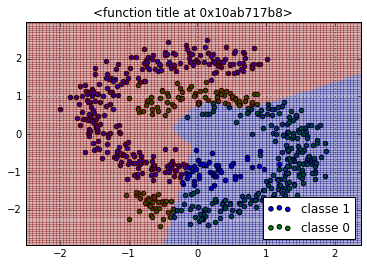

Nb de neurones =  150  error pred a train =  10.0 %
 errorValid =  18.636363636363637


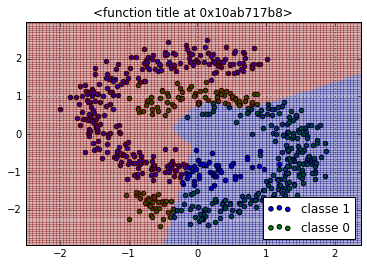

Nb de neurones =  200  error pred a train =  10.0 %
 errorValid =  19.545454545454547


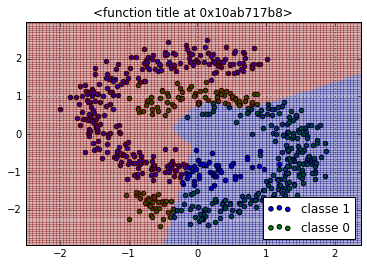

Nb de neurones =  250  error pred a train =  10.0 %
 errorValid =  18.181818181818183


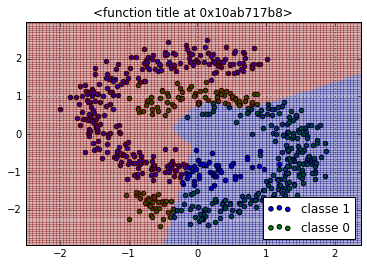

Nb de neurones à erreur minimale =  250  et erreur valid de  18.181818181818183 %
Erreur train =  10.0  errorValid =  19.09090909090909  errorTest =  20.90909090909091
 Frontiere de decision sur test


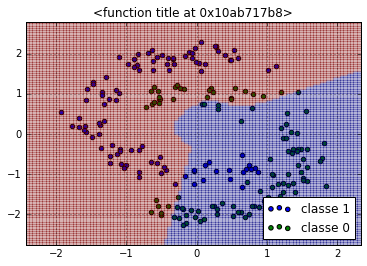

In [26]:
#dh = 200 #Nb de neurones
d = 2 # Nb d'entrées
m = 2 # Nb de sorties
k = 10 # min-batch
epsilon = 1e-5
nEpoc = 1
lamdas = np.matrix([[0.001, 0.0011],[0.0001, 0.00006]])
learning0_rate = 0.21
errorVL = []
dhLL = []
print('Cas effet du nb de neurones ',' Nb d epoque = ',nEpoc,' learning_rate = ',learning_rate,' lamdas = ',lamdas)
for dh in range(50,260,50):
    dhLL.append(dh)
    nnet2 = MLP(d, m, dh, epsilon,nEpoc)
    errorP = nnet2.train(train, target, lamdas, learning_rate)
    print('Nb de neurones = ',dh,' error pred a train = ',errorP[nEpoc-1],'%')
    errorValid = nnet2.test(valid,targetValid)
    errorVL.append(errorValid)
    print(' errorValid = ',errorValid)
    nnet.show_decision_regions(MoonTrain)
print('Nb de neurones à erreur minimale = ',dhLL[argmin(errorVL)],' et erreur valid de ',min(errorVL),'%')
dhOpti = dhLL[argmin(errorVL)]
nnet2 = MLP(d, m,dhLL[argmin(errorVL)], epsilon,nEpoc)
errorP = nnet2.train(train, target, lamdas, learning_rate)
errorValid = nnet2.test(valid,targetValid)
errorTest = nnet2.test(test,targetTest)
print('Erreur train = ',errorP[0],' errorValid = ',errorValid,' errorTest = ',errorTest)
print(' Frontiere de decision sur test')
nnet.show_decision_regions(MoonTest)

####5.3 Effet d'arrêts prématurés

Cas effet d arrets prematures; nb de neurones =  250  Nb d epoque max =  10  learning_rate =  0.21  lamdas =  [[  1.00000000e-03   1.10000000e-03]
 [  1.00000000e-04   6.00000000e-05]]
Nb d epoque a erreur validation min =  8
A meilleur nb de epoque =  8  errorTrain =  [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 0.0] %
 errorValid =  15.0 %  errorTest =  13.636363636363637 %
 Frontiere de decision sur test


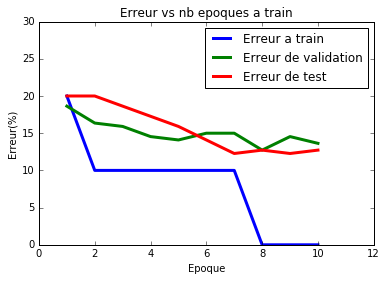

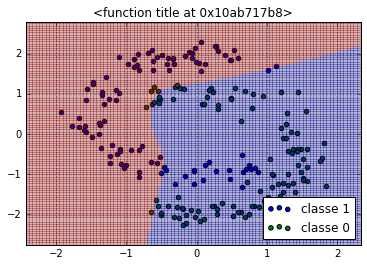

In [27]:
#dh = 200 #Nb de neurones
dh = dhOpti
d = 2 # Nb d'entrées
m = 2 # Nb de sorties
k = 10 # min-batch
epsilon = 1e-5
nEpocMax = 10
lamdas = np.matrix([[0.001, 0.0011],[0.0001, 0.00006]])
learning_rate = 0.21
errorValidL = []
errorTestL = []
print('Cas effet d arrets prematures; nb de neurones = ',dh,' Nb d epoque max = ',nEpocMax,' learning_rate = ',learning_rate,' lamdas = ',lamdas)
for nEpoc in range(1,nEpocMax+1):
    nnet = MLP(d, m, dh, epsilon,nEpoc)
    errorTrain = nnet.train(train, target, lamdas, learning_rate)
    errorValid = nnet.test(valid,targetValid)
    errorValidL.append(errorValid)
    errorTest = nnet.test(test,targetTest)
    errorTestL.append(errorTest)
    #for i in range(len(errorTrain)):
        #print ' Epoque = ',i+1,' erreur train = ',errorTrain[i],'%'     
    #print ' errorValid  = ',errorValid,'%'
x = linspace(1,nEpocMax,10) # linspace va generer un vecteur de 100 nombres entre -3 et 3
plt.figure()     
line_up = plt.plot(x, errorTrain,color='blue',linewidth=3.0,label='Erreur a train') 
line_down = plt.plot(x, errorValidL,color='green',linewidth=3.0,label='Erreur de validation')
line_mid = plt.plot(x, errorTestL,color='red',linewidth=3.0,label='Erreur de test')
plt.legend([line_up, line_down,line_mid])
plt.xlabel('Epoque')
plt.ylabel('Erreur(%)')
plt.title('Erreur vs nb epoques a train')
plt.xlim(0,nEpocMax+2)
plt.ylim(0, max(max(errorTrain),max(errorValidL),max(errorTestL)) + 10)
plt.legend(loc='upper right')
print('Nb d epoque a erreur validation min = ',argmin(errorValidL)+1)
nnet = MLP(d, m, dh, epsilon,argmin(errorValidL)+1)
errorTrain = nnet.train(train, target, lamdas, learning_rate)
errorValid = nnet.test(valid,targetValid)
errorTest = nnet.test(test,targetTest)
print('A meilleur nb de epoque = ',argmin(errorValidL)+1,' errorTrain = ',errorTrain,'%')
print(' errorValid = ',errorValid,'%',' errorTest = ',errorTest,'%')
print(' Frontiere de decision sur test')
nnet.show_decision_regions(MoonTest)

## Question 6

In [28]:
class MLPBatch(MLP):
    def train(self, train, target, lamdas, learning_rate, k):
        self.total_grad = 0
        split_indices = list(range(k, train.shape[0], k))
        train_splits = np.split(train, split_indices)
        target_splits = np.split(target, split_indices)
        
        for i in list(range(0, len(train_splits) - 1, 1)):
            x = train_splits[i]
            y = target_splits[i]
            
            fprop_r = fprop(self.W1, self.W2, self.b1, self.b2, x, y)
            bprop_r = bprop(fprop_r, self.W1, self.W2, self.b1, self.b2, x, y, self.m)
            
            self.total_grad += np.sum(bprop_r['grad_oa'])
            
            regularization = lamdas[0,0]*self.W1.sum() + \
                lamdas[0,1]*np.square(self.W1).sum() + \
                lamdas[1,0]*self.W2.sum() + \
                lamdas[1,1]*np.square(self.W2).sum()
            
            
            self.W1 -= ((learning_rate*bprop_r['grad_w1']/k) + regularization)
            self.W2 -= ((learning_rate*bprop_r['grad_w2']/k) + regularization)
            
            #self.b1 -= (learning_rate*np.matrix(bprop_r['grad_b1']) + regularization)
            #self.b2 -= (learning_rate*bprop_r['grad_b2'] + regularization)
            self.b1 -= (learning_rate*np.matrix(bprop_r['grad_b1']))
            self.b2 -= (learning_rate*bprop_r['grad_b2'])
        
        
    def verify_gradient(self, train, target, k):
        x = train[:k]
        y = target[:k]

        fprop_r = fprop(self.W1, self.W2, self.b1, self.b2, x, y)
        bprop_r = bprop(fprop_r, self.W1, self.W2, self.b1, self.b2, x, y, self.m)
        
        L = np.sum(fprop_r['loss'])

        grad_w2_diff = check_grad_w2(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)
        grad_w1_diff = check_grad_w1(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)
        grad_b2_diff = check_grad_b2(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)
        grad_b1_diff = check_grad_b1(L, self.W1, self.W2, self.b1, self.b2, x, y, self.epsilon)

        grad_ratio_b1 = (bprop_r['grad_b1'] + self.epsilon) / (grad_b1_diff + self.epsilon)
        grad_ratio_w1 = (bprop_r['grad_w1'] + self.epsilon) / (grad_w1_diff + self.epsilon)
        grad_ratio_b2 = (bprop_r['grad_b2'] + self.epsilon) / (grad_b2_diff + self.epsilon)
        grad_ratio_w2 = (bprop_r['grad_w2'] + self.epsilon) / (grad_w2_diff + self.epsilon)
        
        def check_grad_ratio(ratio):
            return (ratio > 0.99).all() and (ratio < 1.01).all()

        if check_grad_ratio(grad_ratio_b2) and check_grad_ratio(grad_ratio_w2) and check_grad_ratio(grad_ratio_b1) and check_grad_ratio(grad_ratio_w1):
            print('Gradient verified for k={0} ✓'.format(k))
        else:
            print('Gradient error for k={0} X'.format(k))

Question 6: Processus d'adaptation en lots de K exemples:
1. Ancienne méthode: chaque exemple est pris et traité individuellement par fprop et bprop
        for i in list(range(train.shape[0])):
           x = train[i]  # dimension = 1 X 2
           y = target[i] # dimension = 1 X 1
            
           fprop_r = fprop(self.W1, self.W2, self.b1, self.b2, x, y) # ha = 1 X 1, hs = 1 X 1, os = 1 X 1, oa = 1 X 1, loss = 1
           
           retour de fprop =  return {
                                    'ha': ha,
                                    'hs': hs,
                                    'oa': oa,
                                    'os': os,
                                    'loss': loss
                                    }
           
           bprop_r = bprop(fprop_r, self.W1, self.W2, self.b1, self.b2, x, y, self.m) # tous des scalaires
           
           retour de bprop = return {
                                      'grad_w1': grad_w1,
                                      'grad_b1': grad_b1,
                                      'grad_ha': grad_ha,
                                      'grad_hs': grad_hs,
                                      'grad_w2': grad_w2,
                                      'grad_b2': grad_b2,
                                      'grad_oa': grad_oa
                                        }
           

2. Nouvelle méthode: l'ensemble d'exemples est divisé est (nb d'exemples total/K) batch de K exemples, chacun étant par la suite traité par fprop et bprop 
        split_indices = list(range(k, train.shape[0], k))
        train_splits = np.split(train, split_indices)
        target_splits = np.split(target, split_indices)
        for i in list(range(0, len(train_splits) - 1, 1)):
            x = train_splits[i] # dimension = k X 2
            y = target_splits[i] # dimension = k X 1
            
        fprop_r = fprop(self.W1, self.W2, self.b1, self.b2, x, y) # ha = k X 1, hs = k X 1, os = k X 1, oa = k X 1, loss = 1
        
                retour de fprop =  return {
                                            'ha': ha,
                                            'hs': hs,
                                            'oa': oa,
                                            'os': os,
                                            'loss': loss
                                            }       
        
        bprop_r = bprop(fprop_r, self.W1, self.W2, self.b1, self.b2, x, y, self.m) # tous des scalaires
        
                retour de bprop = return {
                                      'grad_w1': grad_w1,
                                      'grad_b1': grad_b1,
                                      'grad_ha': grad_ha,
                                      'grad_hs': grad_hs,
                                      'grad_w2': grad_w2,
                                      'grad_b2': grad_b2,
                                      'grad_oa': grad_oa
                                        }


Gradient verified for k=10 ✓


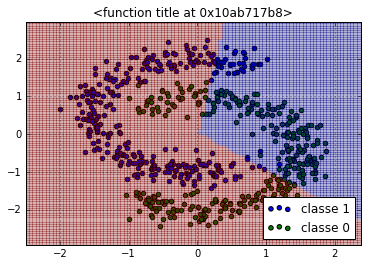

In [29]:
dh = 200
d = 2
m = 2
k = 10
epsilon = 1e-5
nEpoc = 1
nnet_batch = MLPBatch(d, m, dh, epsilon,nEpoc)

learning_rate = 0.21

nnet_batch.verify_gradient(train, target, k)
nnet_batch.train(train, target, lamdas, learning_rate, k)
nnet_batch.show_decision_regions(MoonTrain)

## Question 7

Pour k=1 les gradients total so presque égales

In [30]:
dh = 200
d = 2
m = 2
k = 1
epsilon = 1e-5
nEpoc = 1
nnet_batch_k_1 = MLPBatch(d, m, dh, epsilon,nEpoc)
nnet_k_1 = MLP(d, m, dh, epsilon,nEpoc)

nnet_batch_k_1.W1 = nnet_k_1.W1.copy()
nnet_batch_k_1.W2 = nnet_k_1.W2.copy()
nnet_batch_k_1.b1 = nnet_k_1.b1.copy()
nnet_batch_k_1.b2 = nnet_k_1.b2.copy()

nnet_batch_k_1.train(train, target, lamdas, learning_rate, k)
nnet_k_1.batch_train(train, target, lamdas, learning_rate, k)

print(nnet_batch_k_1.total_grad)
print(nnet_k_1.total_grad)

4.93311988481e-18
-1.31364645724e-16


In [31]:
dh = 200
d = 2
m = 2
k = 2
epsilon = 1e-5
nEpoc = 1
nnet_batch_k_10 = MLPBatch(d, m, dh, epsilon,nEpoc)
nnet_k_10 = MLP(d, m, dh, epsilon,nEpoc)

nnet_batch_k_10.W1 = nnet_k_10.W1.copy()
nnet_batch_k_10.W2 = nnet_k_10.W2.copy()
nnet_batch_k_10.b1 = nnet_k_10.b1.copy()
nnet_batch_k_10.b2 = nnet_k_10.b2.copy()

nnet_batch_k_10.train(train, target, lamdas, learning_rate, k)
nnet_k_10.batch_train(train, target, lamdas, learning_rate, k)

print(nnet_batch_k_10.total_grad)
print(nnet_k_10.total_grad)

7.1123662515e-17
1.49077798717e-17


## Question 8

In [32]:
import gzip,pickle
f=gzip.open('mnist.pkl.gz')
dataMNIST=pickle.load(f, encoding='latin')

"""data[0][0]: matrice de train data
data[0][1]: vecteur des train labels

data[1][0]: matrice de valid data
data[1][0]: vecteur des valid labels

data[2][0]: matrice de test data
data[2][0]: vecteur des test labels"""

#print 'dataMNIST[0][0].shape = ',dataMNIST[0][0].shape #(50000, 784)
#print 'dataMNIST[0][1].shape = ',dataMNIST[0][1].shape #(50000,)
#print 'dataMNIST[1][0].shape = ',dataMNIST[1][0].shape #(10000, 784)
#print 'dataMNIST[1][1].shape = ',dataMNIST[1][1].shape #(10000,)
#print 'dataMNIST[2][0].shape = ',dataMNIST[2][0].shape #(10000, 784)
#print 'dataMNIST[2][1].shape = ',dataMNIST[2][1].shape #(10000,)

MNIST_xtrain = np.matrix(dataMNIST[0][0])
MNIST_xvalid = np.matrix(dataMNIST[1][0])
MNIST_xtest = np.matrix(dataMNIST[2][0])
MNIST_ytrain = np.array(dataMNIST[0][1])
MNIST_yvalid = np.array(dataMNIST[1][1])
MNIST_ytest = np.array(dataMNIST[2][1])

In [33]:
import time
dh = 200
d = MNIST_xtrain.shape[1]
m = 10
k = 100
epsilon = 1e-5
nEpoc = 1
nnet = MLP(d, m, dh, epsilon,nEpoc)
lamdas = np.matrix([[0.001, 0.0011],[0.0001, 0.00006]])
#lamdas = np.matrix([[0.001, 0.0006],[0.004, 0.006]])
learning_rate = 0.21
print('MNIST_ytrain[0]=',MNIST_ytrain[0])
print(MNIST_ytrain.dtype)
time0 = time.time()

error = nnet.train(MNIST_xtrain, MNIST_ytrain, lamdas, learning_rate)
time1 = time.time()
print('temps = ',time1 - time0,'sec.')
errorValid = nnet.test(MNIST_xvalid,MNIST_yvalid)
errorTest = nnet.test(MNIST_xtest ,MNIST_ytest)
print('Cas de base: nb de neurones = ',dh,' Nb d epoque = ',nEpoc,' learning_rate = ',learning_rate,' lamdas = ',lamdas)
print('Erreur de training = ',error[0],'%',' errorValid = ',errorValid,'%',' errorTest = ',errorTest,'%')


MNIST_ytrain[0]= 5
int64


/Users/mabounassif/miniconda3/envs/udem/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
/Users/mabounassif/miniconda3/envs/udem/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: overflow encountered in square
/Users/mabounassif/miniconda3/envs/udem/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater_equal
/Users/mabounassif/miniconda3/envs/udem/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars


temps =  132.9754478931427 sec.
Cas de base: nb de neurones =  200  Nb d epoque =  1  learning_rate =  0.21  lamdas =  [[  1.00000000e-03   1.10000000e-03]
 [  1.00000000e-04   6.00000000e-05]]
Erreur de training =  90.136 %  errorValid =  90.09 %  errorTest =  90.2 %


Gradient verified for k=10 ✓


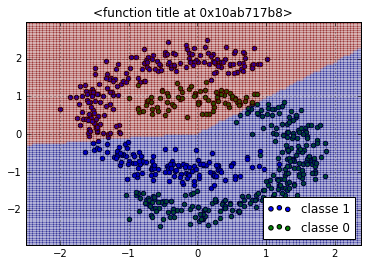

In [34]:
dh = 200
d = 2
m = 2
k = 10
epsilon = 1e-5
nEpoc = 1
nnet_batch = MLPBatch(d, m, dh, epsilon,nEpoc)

learning_rate = 0.21

nnet_batch.verify_gradient(train, target, k)
nnet_batch.train(train, target, lamdas, learning_rate, k)
nnet_batch.show_decision_regions(MoonTrain)